In [1]:
import sys
from pathlib import Path

In [2]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from importlib import reload

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Datasets loading

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Review: 
https://arxiv.org/abs/2012.02974


## Prediction ahead

Datasets available :

* MackeyGlass
* Lorenz
* Sunspot

## Classification

Datasets available :

* Custom :  FSDD, HAART, JapaneseVowels
* Aeon : SpokenArabicDigits, CatsDogs, LSST
* Torchaudio: SPEECHCOMMANDS

More on https://www.timeseriesclassification.com/dataset.php or https://pytorch.org/audio/stable/datasets.html

 Number of instances =  164
 Shape of X =  (14773, 1)
 Shape of y =  (164, 2)
 Meta data =  {'problemname': 'heartbeat', 'timestamps': False, 'missing': False, 'univariate': True, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1']}
Multivariate =  False


/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_20495/1646178259.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fontsize)


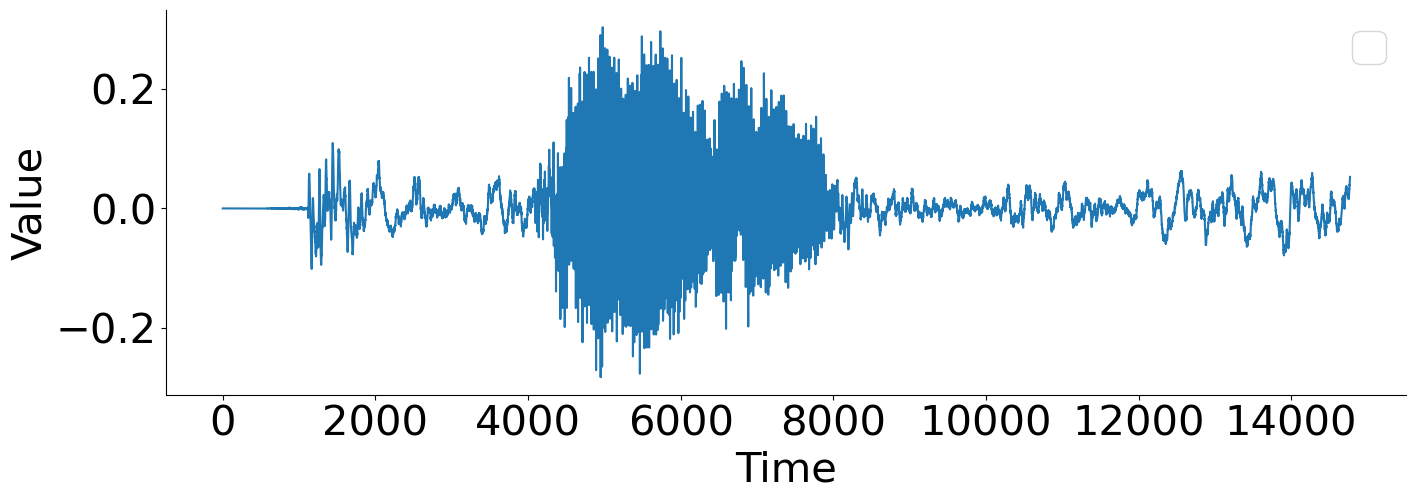

In [3]:
from datasets.load_classification import load_dataset_classification
is_instances_classification = True
spectral_representation = "mfcc"  # Can be None, "stft" or "mfcc"

dataset_name = "CatsDogs"

use_spectral_representation, is_multivariate, sampling_rate, X_train_raw, X_test_raw, Y_train_raw, Y_test, groups = load_dataset_classification(dataset_name)


fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(range(len(X_train_raw[0])), X_train_raw[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fontsize=30
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Time', size=fontsize)
plt.ylabel('Value', size=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

# Cross validation

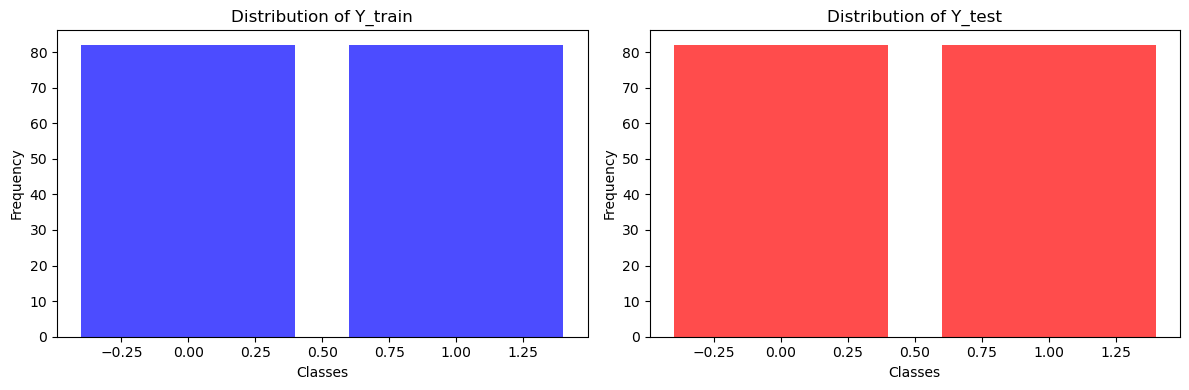

In [4]:
from datasets.preprocessing import plot_data_distribution

# Plot data distribution
if is_instances_classification:
    plot_data_distribution(Y_train_raw, Y_test, val = False)


In [5]:
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, StratifiedGroupKFold
from datasets.preprocessing import flexible_indexing
from datasets.preprocessing import plot_data_distribution

# CROSS-VALIDATION METHODS
# SEED
SEED = 49387

use_cross_validation = False

if use_cross_validation: # we split train between train and val
    if is_instances_classification:
        if groups is None:
            splits = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED).split(X_train_raw, np.argmax(Y_train_raw, axis=1))
        else:
            splits = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=SEED).split(X_train_raw, np.argmax(Y_train_raw, axis=1), groups)
    else: #prediction
        splits = TimeSeriesSplit(n_splits=2).split(X_train_raw)
    
    for i, (train_index, val_index) in enumerate(splits):
        X_train = flexible_indexing(X_train_raw, train_index)
        X_val = flexible_indexing(X_train_raw, val_index)
        Y_train = flexible_indexing(Y_train_raw, train_index)
        Y_val = flexible_indexing(Y_train_raw, val_index)
        # SPLITS
        if is_multivariate and not is_instances_classification:
            X_train_band, X_val_band, X_test_band = X_train, X_val, X_test_raw
            del X_train, X_val
        else:
            X_test = X_test_raw

    if is_instances_classification:
        plot_data_distribution(Y_train, Y_val, val = True)
else: # then we use the test dataset
    if is_multivariate:
        X_train_band, X_test_band = X_train_raw, X_test_raw
        del X_train_raw, X_test_raw
        X_val_band = None
    else:
        X_test, X_train = X_test_raw, X_train_raw
        X_val, X_val_band = None, None
        del X_train_raw, X_test_raw
    Y_train = Y_train_raw
    del Y_train_raw

# Preprocessing

Spectrograms_vs_Cochleagrams : https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

## Multivariate generation (if not multivariate) and train_validation split

Frequency limit:  5000.0 (Shannon sampling theorem)


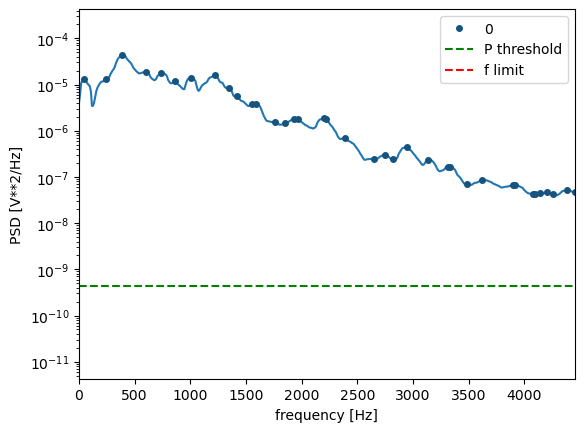

Smoothed peaks:  37
Frequency limit:  5000.0 (Shannon sampling theorem)


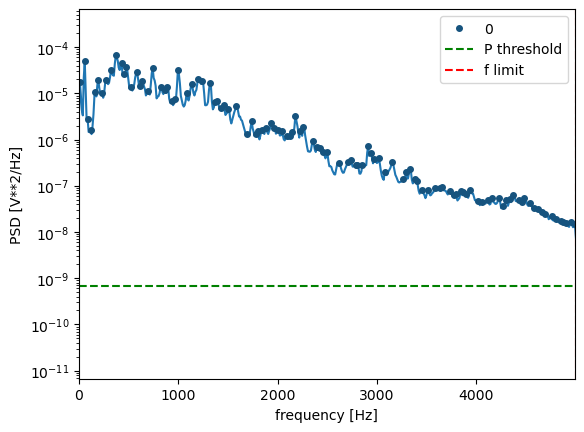

Non-smoothed peaks:  110


In [6]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

freq_train_data = X_train_band if is_multivariate else X_train
flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data

WINDOW_LENGTH = 10

smoothed_peaks_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=True)
nb_smoothed = len(smoothed_peaks_freqs[0]) if is_multivariate else len(smoothed_peaks_freqs)
print("Smoothed peaks: ", nb_smoothed)

peak_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=1, threshold=1e-5, nperseg=1024, visualize=True)
nb_peaks = len(peak_freqs[0]) if is_multivariate else len(peak_freqs)
print("Non-smoothed peaks: ", nb_peaks)

In [7]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

# if it has use_spectral_representation, then it is multivariate
if use_spectral_representation == True: 
    if is_multivariate==False:
        raise ValueError("Cannot use spectral representation if it's not multivariate !")

if not is_multivariate:
    print(f"Converting single variate to {spectral_representation}")
    X_train_band = generate_multivariate_dataset(
        X_train, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
    )
    if use_cross_validation:
        X_val_band = generate_multivariate_dataset(
            X_val, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    else:
        X_test_band = generate_multivariate_dataset(
            X_test, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    if spectral_representation is not None:
        use_spectral_representation = True
elif is_multivariate and not use_spectral_representation:
    print(f"Converting multivariate to {spectral_representation}") # if None we convert to temporal
    X_train_band = generate_multivariate_dataset(
        X_train_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
    )
    if use_cross_validation:
        X_val_band = generate_multivariate_dataset(
            X_val_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    else:
        X_test_band = generate_multivariate_dataset(
            X_test_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
else:
    print("Data is already spectral, nothing to do")

Converting single variate to mfcc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your s

### Visualisation

Power spectrogram


/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_20495/1066028117.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fontsize)


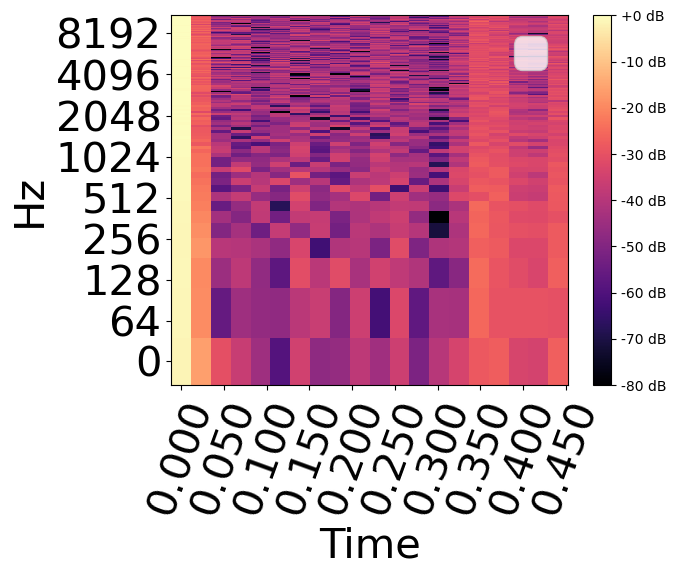

In [8]:
import librosa 

if use_spectral_representation is True:
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(X_train_band[1], ref=np.max), y_axis='log', x_axis='time', ax=ax)
    print('Power spectrogram')
    plt.xticks(rotation=70)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
else:
    test_x = X_val_band if use_cross_validation else X_test_band
    test_y = Y_val if use_cross_validation else Y_test
    # Concatenate train and test arrays for plotting
    combined_data = np.concatenate((X_train_band, test_x), axis=0)
    combined_Y = np.concatenate((Y_train, test_y), axis=0)
    
    # Calculate the merge point index
    merge_point_index = X_train_band.shape[0] if not is_instances_classification else len(X_train_band)
    merge_point_index = 250
    # Define the range around the merge point to plot
    WATCH_FROM = merge_point_index - 250
    WATCH_TO = merge_point_index + 250
    DIFF = WATCH_TO - WATCH_FROM 
    flat_peak_freqs = np.hstack(peak_freqs) if is_multivariate else peak_freqs

    print(WATCH_FROM, WATCH_TO)
    # Plot for a subset N features within a range arround transition from train to test
    fig, ax = plt.subplots(figsize=(16, 8))
    nb_variables = X_train_band.shape[1] if not is_instances_classification else X_train_band[0].shape[1]
    for i in np.random.randint(0, nb_variables, size=3): 
        plt.plot(range(DIFF), combined_data[:, i][WATCH_FROM:WATCH_TO], label=f'Feature {i} at {round(flat_peak_freqs[i], 1)} Hz')
    #plt.plot(steps, combined_Y[steps], label="Prediction")
    print('Feature Values Around Merge Point')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Sample Index')
    plt.ylabel('Feature Value')

fontsize=30
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel(plt.gca().get_xlabel(), fontsize=fontsize)
plt.ylabel(plt.gca().get_ylabel(), fontsize=fontsize)
plt.legend(fontsize=fontsize)

## Standardizing the amplitudes

In [9]:
from sklearn.preprocessing import MinMaxScaler
from datasets.preprocessing import scale_data

scaler_multi = MinMaxScaler(feature_range=(0, 1))
X_train_band, X_val_band, X_test_band = scale_data(X_train_band, X_val_band, X_test_band, scaler_multi, is_instances_classification)
            
if not is_multivariate:
    scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
    X_train, X_val, X_test = scale_data(X_train, X_val, X_test, scaler_multi, is_instances_classification)       


## Noizing

In [10]:
# Define noise parameter
noise_std = 0.001

In [11]:
from datasets.preprocessing import add_noise, duplicate_data

#Train/Val/Test
if is_instances_classification:
    # NOISE
    # UNI
    if not is_multivariate:
        X_train_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train, desc="TRAIN")]
        if X_val is not None:
            X_val_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_val, desc="VAL")]
        X_test_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test, desc="TEST")]
        
    # MULTIX
    X_train_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train_band, desc="TRAIN")]
    if X_val_band is not None:
        X_val_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_val_band, desc="VAL")]
    X_test_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test_band, desc="TEST")]

else:  #if prediction
    # NOISE
    # UNI
    if not is_multivariate:
        X_train_noisy = add_noise(X_train, noise_std)
        X_test_noisy = add_noise(X_test, noise_std)
        if X_val is not None:
            X_val_noisy = add_noise(X_val, noise_std)

    # MULTI
    X_train_band_noisy = add_noise(X_train_band, noise_std)
    if X_val_band is not None:
        X_val_band_noisy = add_noise(X_val_band, noise_std)
    X_test_band_noisy = add_noise(X_test_band, noise_std)


TEST: 100%|██████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 19852.40it/s]


## Pretrain

In [ ]:
# Define the number of instances you want to select
x_size = len(X_train_band) if is_multivariate else len(X_train)
num_samples_for_pretrain = 500 if x_size >= 500 else x_size
if is_instances_classification:
    indices = np.random.choice(x_size, num_samples_for_pretrain, replace=False)
else:
    indices = range(x_size)
    
if not is_multivariate:
    X_pretrain_uni = np.array(X_train, dtype=object)[indices]
    X_pretrain_noisy = np.array(X_train_noisy, dtype=object)[indices]
X_pretrain_band = np.array(X_train_band, dtype=object)[indices]
X_pretrain_band_noisy = np.array(X_train_band_noisy, dtype=object)[indices]


# Generating reservoirs

We are interrested in two technique to genereate reservoir. 
* One is called hag, was studied in previous paper, and recombines inputs based on their activity to reach a given activation target.
* The other called DESP recombines inputs in order to reach a given standard deviation of activation

## Data format

In [ ]:
if is_instances_classification:
    common_index = 1
    print("Common index for multivariate classification should be 1")
    print("\nCheck it ! \nFirst array ", X_train_band[0].shape, " and second array", X_train_band[2].shape)
    common_size = X_train_band[0].shape[common_index]
else:
    common_index = 1
    print("Common index for multivariate prediction should be 1")
    print("\nCheck it ! \nFirst array ", X_train_band.shape, " and second array", X_train_band.shape)
    common_size = X_train_band.shape[common_index]

common_size

In [ ]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/np.max(np.hstack(peak_freqs))
max_window_size = sampling_rate/np.min(np.hstack(peak_freqs))

print(min_window_size)
print(max_window_size)

### Visualisation checks

In [ ]:
if is_instances_classification:
    train_band_data =  np.concatenate(X_train_band, axis=0).T
else:
    train_band_data =  X_train_band.T

START = 0
END = 500
DIFF = END - START
#CPlot the two for different frequencies
# Define your frequency indices in a list
random_neurons_indices = np.random.randint(0, train_band_data.shape[0], size=3)
flat_peak_freqs = np.hstack(peak_freqs) if is_multivariate else peak_freqs

fig, ax = plt.subplots(figsize=(16, 8))
colors = color_palette("tab20")
j = 0
for i in random_neurons_indices:
    plt.plot(range(DIFF), train_band_data[i, START:END], color=colors[j], label=f'Feature {i} at {round(flat_peak_freqs[i], 1)} Hz')
    j += 1
#plt.plot(steps, combined_Y[steps], label="Prediction")
print('Scaled Feature Values')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fontsize=30
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Time', size=fontsize)
plt.ylabel('Value', size=fontsize)
plt.legend(fontsize=fontsize)


## Shared parameters

### Reservoir parameters

In [ ]:
from reservoir.activation_functions import tanh, heaviside, sigmoid, softplus, heaviside

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))tanh(x)
activation_function = lambda x : tanh(x)

x=np.linspace(0, 2, 100)
plt.plot(x, activation_function(x))
plt.grid()

**common_size** : the number of different dimensions in the input data

**K** : the number of neurons that will receive a particular time serie as input 

In [ ]:
import math 

RESERVOIR_SIZE = 500

# We want the size of the reservoir to be at least RESERVOIR_SIZE
K = math.ceil(RESERVOIR_SIZE / common_size)
n = common_size * K
print("Dimension of our reservoir :", n)
print("Copy of each time serie :", K)

In [ ]:
common_size

### Hyperparameters

#### To set your own

#### To load from optuna

In [ ]:
import optuna
from performances.utility import camel_to_snake

function_name = "hadsp" # "desp" ou "hadsp" or "random"

variate_type = "multi" # "multi" ou "uni"
data_type = "normal" # "normal" ou "noisy"

if variate_type == "uni" and is_multivariate:
    raise ValueError(f"Invalid variable type: {variate_type}")
    
study_name = function_name + "_" + dataset_name + "_" + data_type + "_" + variate_type
url= "sqlite:///optuna_" + camel_to_snake(dataset_name) + "_db.sqlite3"

study = optuna.load_study(study_name=study_name, storage=url) # To load an existing study

# Print the best hyperparameters
print("Best hyperparameters: ")
for param_name, param_value in study.best_trial.params.items():
    globals()[param_name] = param_value
    print(param_name, param_value)


if not is_instances_classification:
    use_full_instance = None

if function_name == "hadsp" or function_name == "desp":
    max_increment_span = int(max_window_size) if int(max_window_size) - 100 < 0 else int(max_window_size) - 100
    MAX_TIME_INCREMENT = time_increment + time_increment_span #int(max_window_size) or None or TIME_INCREMENT


## Function to initialise and generate reservoir


In [ ]:
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm
from scipy import sparse


function_name = "hadsp" # "desp" ou "hadsp"

def initialise_and_train(input_scaling, n, input_connectivity, connectivity, K, bias_scaling, seed, training_set):
    
    Win, W, bias = init_matrices(n, input_connectivity, connectivity,  K, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling

    if function_name == "hadsp":
        W, (state_history, delta_z_history, W_history) = run_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, time_increment, weight_increment,
                                target_rate, rate_spread, function_name, is_instance=is_instances_classification, use_full_instance = use_full_instance, 
                                max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method = "pearson", 
                                n_jobs = 12, visualize=False, record_history=True)

    elif function_name == "desp":
        W, (state_history, delta_z_history, W_history) = run_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, time_increment, weight_increment,
                            min_variance, variance_spread, function_name, is_instance=is_instances_classification, use_full_instance = use_full_instance, 
                            max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method = "pearson", 
                            intrinsic_saturation=intrinsic_saturation, intrinsic_coef=intrinsic_coef, n_jobs = 12, visualize=False, record_history=True)

    connectivity =  np.count_nonzero(W) / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = np.max(np.abs(eigen))

    
    
    return Win, W, bias, connectivity, sr, state_history, delta_z_history, W_history


## Multivariate case

In [ ]:
(Win_hag_multi, 
 W_hag_multi, 
 bias_hag_multi, 
 connectivity_band, 
 sr_hag_multi, 
 state_history_hag,
 delta_z_history,
 W_history) = initialise_and_train(input_scaling, n, input_connectivity, connectivity, K, bias_scaling, SEED, X_pretrain_band)


from matplotlib.colors import ListedColormap

custom_colormap = ListedColormap(np.vstack((plt.cm.cividis(0.0), plt.cm.cividis(np.linspace(0.5, 1, 128)))))
vmin = 0
vmax = max(np.max(Win_hag_multi), np.max(W_hag_multi))
fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[0.5,6,0.2]))
heatmap(Win_hag_multi, cmap=custom_colormap, cbar=False, square=True, ax=axs[0], vmin=vmin, vmax=vmax)
heatmap(W_hag_multi, cmap=custom_colormap, yticklabels=False, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax)
fig.colorbar(axs[1].collections[0], cax=axs[2])

#### Algorithm Dynamics

In [ ]:
if delta_z_history is not None:
    fig, ax = plt.subplots(figsize=(16, 5))
    print(f'Dynamics')
    
    # NEURON ACTIVITY PLOT
    random_neurons_indices =  np.sort(np.random.randint(RESERVOIR_SIZE, size=7)) #Size max is 19 because there is not enough colors
    random_neurons_indices = np.append(random_neurons_indices, 51)
    colors = color_palette("tab20")
    # NUMBER_OF_STEP_TO_WATCH
    WATCH_FROM = 0
    WATCH_TO = 3000
    neurons_evolution = np.array(delta_z_history)[WATCH_FROM:WATCH_TO]
    x =range(len(delta_z_history))[WATCH_FROM:WATCH_TO]
    j = 0
    for i in random_neurons_indices:
        ax.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
        ax.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
        j += 1
    fontsize=18
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=fontsize)
    plt.xlabel('Time', size=fontsize)
    plt.ylabel('Value', size=fontsize)
    plt.legend(fontsize=fontsize)


In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
print(f'Dynamics')

# NEURON ACTIVITY PLOT 
random_neurons_indices =  np.sort(np.random.randint(RESERVOIR_SIZE, size=4)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 5000
neurons_evolution = np.array(state_history_hag)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_hag))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Time', size=fontsize)
plt.ylabel('Value', size=fontsize)
plt.legend(fontsize=fontsize)

#### Random matrice

In [ ]:
# random + multi

#connectivity_band = 0.397219709836612
#sr_hag_multi = 1.0
#bias_scaling = 0.005
#input_scaling = 0.11499999999999999
Win_random_multi, W_random_multi, bias_random_multi =  init_matrices(n, 1, connectivity_band, K, sr_hag_multi, seed=19823)
bias_random_multi= bias_random_multi*bias_scaling
Win_random_multi= Win_random_multi*input_scaling

eigen_random_multi = sparse.linalg.eigs(W_random_multi, k=1, which="LM", maxiter=W_random_multi.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_random_multi = np.max(np.abs(eigen_random_multi))


## Richness

### Pearson

In [ ]:
from analysis.richness import pearson
num_windows = 150

mean_correlations_hag, std_correlations_hag = pearson(state_history_hag, num_windows=num_windows)

In [ ]:
from reservoir.reservoir import update_reservoir

states_history_multi = []
neurons_state = np.random.uniform(0, 1, bias_hag_multi.size)
inputs = np.concatenate(X_pretrain_band, axis=0) if is_instances_classification else X_pretrain_band
for input_value in inputs:
    neurons_state = update_reservoir(W_hag_multi, Win_hag_multi, input_value, neurons_state, leaky_rate, bias_hag_multi, activation_function)
    states_history_multi.append(neurons_state)

mean_correlations_multi, std_correlations_multi = pearson(states_history_multi, num_windows=num_windows)

In [ ]:

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(num_windows)
plt.plot(time_windows, mean_correlations_multi, marker='.', linestyle='-', color='b',  label="with same input after training")
plt.fill_between(time_windows, np.array(mean_correlations_multi) - np.array(std_correlations_multi),
                 np.array(mean_correlations_multi) + np.array(std_correlations_multi), color='blue', alpha=0.2)

plt.plot(time_windows, mean_correlations_hag, marker='.', linestyle='-', color='red', label="during training")
plt.fill_between(time_windows, np.array(mean_correlations_hag) - np.array(std_correlations_hag),
                 np.array(mean_correlations_hag) + np.array(std_correlations_hag), color='red', alpha=0.2)
plt.ylim(0, 1)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Correlation', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.grid(True)

In [ ]:
from reservoir.reservoir import update_reservoir

states_history_random = []
neurons_state = np.random.uniform(0, 1, bias_random_multi.size)
inputs = np.concatenate(X_pretrain_band, axis=0) if is_instances_classification else X_pretrain_band
for input_value in inputs:
    neurons_state = update_reservoir(W_random_multi, Win_random_multi, input_value, neurons_state, leaky_rate, bias_random_multi, activation_function)
    states_history_random.append(neurons_state)

mean_correlations_random, std_correlations_random = pearson(np.array(states_history_random), num_windows=num_windows)


# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(num_windows)
plt.plot(time_windows, mean_correlations_random, marker='.', linestyle='-', color='g',  label="with same input for random matrice")
plt.fill_between(time_windows, np.array(mean_correlations_random) - np.array(std_correlations_random),
                 np.array(mean_correlations_random) + np.array(std_correlations_random), color='g', alpha=0.2)
plt.ylim(0, 1)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Correlation', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.grid(True)

In [ ]:

mean_correlations_random, std_correlations_random = pearson(inputs, num_windows=num_windows)


# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(num_windows)
plt.plot(time_windows, mean_correlations_random, marker='.', linestyle='-', color='y',  label="inputs correlation")
plt.fill_between(time_windows, np.array(mean_correlations_random) - np.array(std_correlations_random),
                 np.array(mean_correlations_random) + np.array(std_correlations_random), color='y', alpha=0.2)
plt.ylim(0, 1)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Correlation', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.grid(True)

### IPC

### LUD

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import uncoupled_dynamics

uds_hag = uncoupled_dynamics(np.array(state_history_hag).T, num_windows=num_windows, A=0.99)
uds_multi = uncoupled_dynamics(np.array(states_history_multi).T, num_windows=num_windows, A=0.99)

max_value = np.max([np.max(uds_hag), np.max(uds_hag)])

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(uds_hag))
plt.plot(range(len(uds_hag)), uds_hag, marker='.', linestyle='-', color='r',  label="during training")
plt.plot(range(len(uds_multi)), uds_multi, marker='.', linestyle='-', color='b',  label="with same input after training")
plt.ylim(0, max_value)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Uncoupled Dynamics', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import uncoupled_dynamics

uds_random = uncoupled_dynamics(np.array(states_history_random).T, num_windows=num_windows, A=0.99)

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(uds_random))
plt.plot(time_windows, uds_random, marker='.', linestyle='-', color='g',  label="with same input for random matrice")
plt.ylim(0, max_value)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Uncoupled Dynamics', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

### LUD True

In [ ]:
np.array(state_history_hag).shape

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import eigen_value_spread
num_windows = 150

uds_hag = eigen_value_spread(np.array(state_history_hag), num_windows=num_windows, theta=0.9)
uds_multi = eigen_value_spread(np.array(states_history_multi), num_windows=num_windows, theta=0.9)

max_value = np.max([np.max(uds_hag), np.max(uds_hag)])

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(uds_hag))
plt.plot(range(len(uds_hag)), uds_hag, marker='.', linestyle='-', color='r',  label="during training")
plt.plot(range(len(uds_multi)), uds_multi, marker='.', linestyle='-', color='b',  label="with same input after training")
plt.ylim(0, max_value)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Uncoupled Dynamics', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

In [ ]:
window_data = np.array(state_history_hag).T[:, 1000:2000]
window_data_std = (window_data - np.mean(window_data, axis=0)) / np.std(window_data, axis=0)

U, S, Vt = np.linalg.svd(window_data_std, full_matrices=False)

# Calculate the normalized relevance R_j
R = S / np.sum(S)

# Cumulative sum of R_j
cumulative_R = np.cumsum(R)

# Find the minimum d such that the cumulative sum >= theta
num_components = np.searchsorted(cumulative_R, 0.9) + 1


In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import uncoupled_dynamics

uds_random = eigen_value_spread(np.array(states_history_random),  num_windows=num_windows, theta=0.9)

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(uds_random))
plt.plot(time_windows, uds_random, marker='.', linestyle='-', color='g',  label="with same input for random matrice")
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Uncoupled Dynamics', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

## Univariate case

# Performance

In [ ]:
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score

N_JOBS = -1
RIDGE_COEF= 1e-9 if ridge is None else 10**ridge

## Classification

In [ ]:
if not is_instances_classification:
    raise ValueError("This is not the right Classification section.")

### Classification for multivariate

In [ ]:
print("X_train_band_duplicated example shape :", X_train_band[1].shape)     
print("We should have :", X_train_band[0].shape[1], "==", common_size)

In [ ]:
from performances.esn_model_evaluation import init_and_train_model_for_classification
# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias

train_data_multi = X_train_band # X_train_band_noisy or X_train_band
Y_data = Y_val if use_cross_validation else Y_test

reservoir_hag_multi, readout_hag_multi = init_and_train_model_for_classification(W_hag_multi, Win_hag_multi, bias_hag_multi, leaky_rate, activation_function, train_data_multi, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")

reservoir_random_multi, readout_random_multi = init_and_train_model_for_classification(W_random_multi, Win_random_multi, bias_random_multi, leaky_rate, activation_function, train_data_multi, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")


#### noisy 

In [ ]:
from performances.esn_model_evaluation import predict_model_for_classification, compute_score

test_data_multi_noisy = X_test_band_noisy # X_test_band_noisy or X_test_band

Y_pred_hag_multi = predict_model_for_classification(reservoir_hag_multi, readout_hag_multi, test_data_multi_noisy, N_JOBS)
score = compute_score(Y_pred_hag_multi, Y_data, is_instances_classification, function_name + " multi", verbosity=1)

Y_pred_random_multi = predict_model_for_classification(reservoir_random_multi, readout_random_multi, test_data_multi_noisy, N_JOBS)
score = compute_score(Y_pred_random_multi, Y_data, is_instances_classification, "random multi", verbosity=1)

#### normal

In [ ]:

test_data_multi = X_test_band # X_test_band_noisy or X_test_band

Y_pred_hag_multi = predict_model_for_classification(reservoir_hag_multi, readout_hag_multi, test_data_multi, -1)
score = compute_score(Y_pred_hag_multi, Y_data, is_instances_classification, function_name + " multi", verbosity=1)

Y_pred_random_multi = predict_model_for_classification(reservoir_random_multi, readout_random_multi, test_data_multi, N_JOBS)
score = compute_score(Y_pred_random_multi, Y_data, is_instances_classification, "random multi", verbosity=1)

### Classification for univariate

In [ ]:
if not is_multivariate: 
    # Create a list to store the arrays with the same shape as the expected input of the reservoir

    train_data_uni = [ts.reshape(-1, 1) for ts in X_train]
    test_data_uni = [ts.reshape(-1, 1) for ts in X_test]

    print("number of instances in train_data_uni :", len(train_data_uni), "should be equal to", len(X_train))     
    print("example of train_data_uni train shape :", train_data_uni[0].shape)     
    print("We should have :", train_data_uni[0].shape[1], "==", 1)

In [ ]:
if not is_multivariate:
    reservoir_hag_uni, readout_hag_uni = init_and_train_model_for_classification(W_hag_uni, Win_hag_uni, bias_hag_uni, leaky_rate, activation_function, train_data_uni, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")

    reservoir_random_uni, readout_random_uni = init_and_train_model_for_classification(W_normal, Win_normal, bias_normal, leaky_rate, activation_function, train_data_uni, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")

In [ ]:
if not is_multivariate:
    Y_pred_hag_uni = predict_model_for_classification(reservoir_hag_uni, readout_hag_uni, test_data_uni, N_JOBS)
    score = compute_score(Y_pred_hag_uni, Y_test, is_instances_classification, function_name + " uni", verbosity=1)
    
    Y_pred_normal = predict_model_for_classification(reservoir_random_uni, readout_random_uni, test_data_uni, N_JOBS)
    score = compute_score(Y_pred_normal, Y_test, is_instances_classification, "random uni", verbosity=1)

## Prediction ahead

In [ ]:
if is_instances_classification:
    raise ValueError("This is not the right Classification section.")

### Plot datasets
Noisy or normal dataset can be ploted

In [ ]:
# Concatenate train and test arrays for plotting
combined_data = np.concatenate((X_train_band, X_val_band), axis=0)

# noisy version
combined_data_noisy = np.concatenate((X_train_band, X_val_band_noisy), axis=0)
combined_Y =np.concatenate((Y_train, Y_val), axis=0)

# Calculate the merge point index
merge_point_index = X_train_band.shape[0]

# Define the range around the merge point to plot
start_index = merge_point_index - 100
end_index = merge_point_index + 100

# Plot for a subset N features within a range arround transition from train to test
N = 3
plt.figure(figsize=(16, 5))
for i in [1, 13, 17]: 
    plt.plot(range(start_index, end_index), combined_data_noisy[start_index:end_index, i], label=f'Feature {i}')
plt.plot(range(start_index, end_index), combined_Y[start_index:end_index], label="Prediction")
plt.title('Feature Values Around Merge Point')
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

### Training
Noisy or normal dataset can be used

In [ ]:
import performances.esn_model_evaluation
reload(performances.esn_model_evaluation)
from performances.esn_model_evaluation import init_and_train_model_for_prediction

if not is_multivariate:
    train_data_uni = X_train # X_train_noisy or X_train
    
    # Training random + MG
    esn_random_uni = init_and_train_model_for_prediction(W_normal, Win_normal, bias_normal, leaky_rate, activation_function, train_data_uni, Y_train, RIDGE_COEF)
    
    # Training for hag + MG
    esn_hag_uni = init_and_train_model_for_prediction(W_hag_uni, Win_hag_uni, bias_hag_uni, leaky_rate, activation_function, train_data_uni, Y_train, RIDGE_COEF)

    
train_data_multi = X_train_band # X_train_band_noisy or train_band_inputs

# Training random + bandfilter
esn_random_multi = init_and_train_model_for_prediction(W_random_multi, Win_random_multi, bias_random_multi, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)

# Training output HASDP + bandfilter
esn_hag_multi = init_and_train_model_for_prediction(W_hag_multi, Win_hag_multi, bias_hag_multi, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)
                                                       

### Prediction
Noisy or normal dataset can be used

In [ ]:
if not is_multivariate:
    test_data_uni = X_val # X_val_noisy or X_val

    # Prediction for random + MG
    y_pred_random_uni = esn_random_uni.run(test_data_uni, reset=False) 

    # Prediction for hag + MG
    y_pred_hag_uni = esn_hag_uni.run(test_data_uni, reset=False) 


test_data_multi = X_val_band # X_test_band_noisy_duplicated or X_test_band_duplicated

# Prediction for random + bandfilter
y_pred_random_multi = esn_random_multi.run(test_data_multi, reset=False)

# Prediction for hag + bandfilter
y_pred_hag_multi = esn_hag_multi.run(test_data_multi, reset=False)


In [ ]:
from plots.plots import plot_results
from performances.esn_model_evaluation import compute_score

START_STEP = 30
END_STEP = 500
slice_range = slice(START_STEP, END_STEP)

if not is_multivariate:
    print("nrmse normal         :", compute_score(Y_val[slice_range], y_pred_random_uni[slice_range], is_instances_classification))
    print("nrmse hag          :", compute_score(Y_val[slice_range], y_pred_hag_uni[slice_range], is_instances_classification))

print("nrmse random + band  :", compute_score(Y_val[slice_range], y_pred_random_multi[slice_range], is_instances_classification))
print("nrmse hag + band   :", compute_score(Y_val[slice_range], y_pred_hag_multi[slice_range], is_instances_classification))

plot_results(y_pred_hag_multi, Y_test, 0, 300)


In [ ]:
if not is_multivariate:
    test_data_uni = X_val_noisy # X_val_noisy or X_val

    # Prediction for random + MG
    y_pred_random_uni = esn_random_uni.run(test_data_uni, reset=False) 

    # Prediction for hag + MG
    y_pred_hag_uni = esn_hag_uni.run(test_data_uni, reset=False) 

test_data_multi = X_val_band_noisy # X_test_band_noisy_duplicated or X_test_band_duplicated

# Prediction for random + bandfilter
y_pred_random_multi = esn_random_multi.run(test_data_multi, reset=False)

# Prediction for hag + bandfilter
y_pred_hag_multi = esn_hag_multi.run(test_data_multi, reset=False)


In [ ]:
from plots.plots import plot_results

START_STEP = 30
END_STEP = 500
slice_range = slice(START_STEP, END_STEP)

if not is_multivariate:
    print("nrmse normal         :", compute_score(y_pred_random_uni[slice_range], Y_val[slice_range], is_instances_classification))
    print("nrmse hag          :", compute_score(y_pred_hag_uni[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse random + band  :", compute_score(y_pred_random_multi[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse hag + band   :", compute_score(y_pred_hag_multi[slice_range], Y_val[slice_range], is_instances_classification))

plot_results(y_pred_hag_multi, Y_test, 0, 300)


#### Moving average 

In [ ]:
from performances.esn_model_evaluation import compute_score

# moving average of the y
span=7
pad_width = span // 2

if not is_multivariate:
    ave_y_random_uni = np.convolve(np.pad(y_pred_random_uni.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span
    ave_y_hag_uni = np.convolve(np.pad(y_pred_hag_uni.flatten(), pad_width, mode='edge') , np.ones(span), 'valid') / span
ave_y_random_multi = np.convolve(np.pad(y_pred_random_multi.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span
ave_y_hag_multi = np.convolve(np.pad(y_pred_hag_multi.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span

if not is_multivariate:
    print("nrmse normal         :", compute_score(ave_y_random_uni[slice_range], Y_val[slice_range], is_instances_classification))
    print("nrmse hag          :", compute_score(ave_y_hag_uni[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse random + band  :", compute_score(ave_y_random_multi[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse hag + band   :", compute_score(ave_y_hag_multi[slice_range], Y_val[slice_range], is_instances_classification))
 
plot_results(ave_y_hag_multi.reshape(-1,1), Y_test, 300)

In [ ]:
nrmse_array_random_uni = []
nrmse_array_hag_uni = []
nrmse_array_random_multi = []
nrmse_array_hag_multi = []

for i in range(len(Y_val)-100- step_ahead):
    Y_val_i = Y_val[i:100+i]
    nrmse_array_random_uni.append(compute_score(Y_val_i, y_pred_random_uni[i:100+i], is_instances_classification))
    nrmse_array_hag_uni.append(compute_score(Y_val_i, y_pred_hag_uni[i:100+i], is_instances_classification))
    nrmse_array_random_multi.append(compute_score(Y_val_i, y_pred_random_multi[i:100+i], is_instances_classification))
    nrmse_array_hag_multi.append(compute_score(Y_val_i, y_pred_hag_multi[i:100+i], is_instances_classification))
    
log10_nrmse_random_uni= np.log10(nrmse_array_random_uni)
log10_nrmse_hag_uni = np.log10(nrmse_array_hag_uni)
log10_nrmse_random_multi = np.log10(nrmse_array_random_multi)
log10_nrmse_hag_multi = np.log10(nrmse_array_hag_multi)
plt.figure()
plt.plot(log10_nrmse_random_uni[:1000])
plt.plot(log10_nrmse_hag_uni[:1000])
plt.plot(log10_nrmse_random_multi[:1000])
plt.plot(log10_nrmse_hag_multi[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["hag+band", "random", " random + bandfilter", "hag"])
plt.show()

# Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
# Be really carefull of the column order here !
df_data = scaler.fit_transform(X_pretrain_band.T)
df_data = df_data.T
df = pd.DataFrame(df_data.T)
# Initialize a progress bar for total number of series
progress_bar = tqdm(total=df.shape[1]**2, position=0, leave=True)

# Initialize an empty correlation matrix
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate the correlation for each pair of series
for col1 in df.columns:
    progress_bar.set_description(f"Processing {col1}")
    for col2 in df.columns:
        correlation_matrix.loc[col1, col2] = df[col1].corr(df[col2], method='pearson', min_periods=5)

        progress_bar.update(1)  # Update the progress bar after processing each series
    
progress_bar.close()

# Convert correlation_matrix to numeric as it is stored as objects due to tqdm
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# Perform hierarchical clustering
linked = linkage(correlation_matrix, 'single')

# Get the order of rows/columns after hierarchical clustering
row_order = leaves_list(linked)

# Reorder the correlation matrix
sorted_corr_matrix = correlation_matrix.iloc[row_order, :].iloc[:, row_order]

# Visualize the sorted correlation matrix with a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(sorted_corr_matrix, annot=False, cmap='vlag', vmin=-1, vmax=1)
plt.title('Clustered Pairwise Correlation of Time Series')
plt.show()


In [ ]:
from scipy.sparse import coo_matrix

row_order_r = np.array([i + k for i in row_order*K for k in range(K)])

# Convert the sparse matrix to a dense format (if memory allows)
dense_matrix = W_hag_multi.toarray()

# Reorder the dense matrix using the repeated ordering
reordered_matrix = dense_matrix[np.ix_(row_order_r, row_order_r)]

# Convert the reordered dense matrix back to a sparse format if needed
sparse_reordered_matrix = coo_matrix(reordered_matrix)

In [ ]:
heatmap(sparse_reordered_matrix.todense(), cmap=color_palette("vlag", as_cmap=True))

## Motifs

In [ ]:
import analysis.topology
reload(analysis.topology)
from analysis.topology import motif_distribution, draw_motifs_distribution

motifs_count = motif_distribution(W_hag_multi.A)
draw_motifs_distribution(motifs_count)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom

def analyze_connectivity_matrix(matrix):
    # Extract weights from the matrix (ignoring the diagonal and zeros)
    weights = matrix.flatten()
    weights = weights[weights != 0]
    bin_centers, counts = np.unique(weights, return_counts=True)
    
    # Calculate the difference for all centers
    diffs = np.diff(bin_centers)
    # Add the last difference for the last bin
    diffs = np.append(diffs, diffs[-1])
    
    # Calculate the bin edges based on bin centers and differences
    bin_edges = bin_centers - diffs/2
    # Add the last bin edge
    bin_edges = np.append(bin_edges, bin_centers[-1] + diffs[-1]/2)
    
    # Plot histogram
    plt.bar(bin_centers, counts, align='center', alpha=0.6, width=np.diff(bin_centers).min())
    
    # Fit to Poisson distribution
    lambda_est = np.mean(weights)
    plt.plot(bin_centers, poisson.pmf(range(len(bin_centers)), lambda_est)*counts[0], 'r-', label='Poisson fit')
    
    # Fit to Binomial distribution using derived relations
    mean = np.mean(weights)
    variance = np.var(weights)
    
    # Calculate p and n estimates
    p_est = mean ** 2 / (n * mean - variance) if (n * mean - variance) != 0 else 0
    n_est = int(round(mean / p_est)) if p_est != 0 else 0  # n should be integer

    # Check parameter validity
    if not(0 < p_est < 1):
        print("Estimated parameters are not valid for the Binomial distribution.")
    else:
        x_vals = range(len(bin_centers))
        plt.plot(bin_centers, binom.pmf(x_vals, n_est, p_est) * counts[0], 'g-', label='Binomial fit')

    plt.legend()
    plt.show()

    return {"Poisson": lambda_est, "Binomial": (n_est, p_est)}


# Assuming W_hag_multi.A is your connectivity matrix
analyze_connectivity_matrix(W_hag_multi.A)

In [ ]:
bin_centers = np.array([1.5, 3.5, 5.5, 7.5])
poisson.pmf(np.arange(len([1, 2, 3, 4, 5, 6])), 0.08)

In [ ]:
weights.shape

In [ ]:
W_hag_multi.A.flatten().shape